In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize, LinearConstraint, Bounds
from scipy.integrate import solve_ivp
from scipy import signal
from functools import partial
import matplotlib._color_data as mcd
colors = list(mcd.TABLEAU_COLORS.values())+['#000000']
acolors = ['c','m','y','k']
from cycler import cycler
dcycler = (cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
acycler = (cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=['c', 'm', 'y', 'k']))
fsize = 16
plt.rc('font', size=fsize) #controls default text size
plt.rc('axes', titlesize=fsize) #fontsize of the title
plt.rc('axes', labelsize=fsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fsize) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fsize) #fontsize of the y tick labels
plt.rc('legend', fontsize=fsize) #fontsize of the legend labels

In [2]:
sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.base import *
from tcg_slb.info import additional_phase_abbrevs

In [3]:
from thermoengine.equilibrate import PhaseLibrary
from thermoengine.equilibrate import System
import thermoengine as thermo

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/numdifftools/multicomplex.py:35: DeprecationWarning: `finfo.machar` is deprecated (NumPy 1.22)
  _TINY = np.finfo(float).machar.tiny


In [4]:
pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'tcg_slb_database', 'lib', 'python'+pv, 'site-packages'))

import py_tcg_slb_database as pslb
db = thermo.model.Database.from_thermocodegen(pslb)
all_phases = db.get_all_phases()
std_phases = [ph for ph in all_phases if ph.abbrev not in additional_phase_abbrevs]
phase_library = PhaseLibrary(std_phases)

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code g

### Create a class to handle the isentrope calculation

In [53]:
class Isentrope(object):
    
    t = []
    rho = []
    rho_bar = []
    Ciks = []
    Xiks = []
    Yis = []
    Fis = []
    T = []
    p = []
    
    system = None
    phases = None
    options = None
    
    T0 = None
    d = None
    g = 9.81
    rho0 = None
    p0 = None
    
    Ts = None
    ps = None
    comp = None
    end = None
    
    sol = None
    rtol = None
    atol = None
    options = None
    
    equil_vals = {}
    sol_vals = {}
    
    fig      = None
    
    def __init__(self,phases):
        self.phases  = phases
        self.comp = comp
               
    def set_initial_params(self,Ts,ps,comp,d,**kwargs):
        self.Ts    = Ts
        self.ps    = ps
        self.comp  = comp
        self.d     = d
        
        self.options = kwargs.get('options', {'grid_spacing':1/10})
        
        self.T0 = Ts
        self.equilibrate(Ts,ps)
        self.rho0 = self.equil_vals["rho"]
        self.p0   = Pa2Bar(rho2kgpm3(self.rho0)*self.g*self.d)
        
        self.rtol  = kwargs.get('rtol',1.e-5)
        self.atol  = kwargs.get('atol',1.e-9)

    def solve(self,Ts,ps,comp,d,**kwargs):
        self.set_initial_params(Ts,ps,comp,d,**kwargs)
        
        #self.t = []
        #self.rho = []
        #self.rho_bar = []
        #self.Ciks = []
        #self.Xiks = []
        #self.Yis = []
        #self.Fis = []
        #self.T = []
        #self.p = []
        
        events = []
        
        ui = np.asarray([Ts/self.T0, ps/self.p0])
        self.system = None
        self.sol = solve_ivp(self.rhs, [0,1], ui, dense_output=True, method='BDF', rtol=self.rtol, atol=self.atol, events=events)
        print('{} P_end = {} bar.  Used {} steps.'.format(self.sol.message, self.sol.y[-1][-1]*self.p0, len(self.sol.t)))
        
        self.eval_sol()
        
        return self.sol.success

    def rhs(self,t,u):
        '''
        return rhs of the dimensionaless 1-D isentropic upwelling equations

        Parameters
        ----------

        t: float
            time
        u: array
            solution array [ T, P ]

        '''
        #self.t.append(t)
        #self.rho.append(rho)
        #self.rho_bar.append(rho_bar)
        #self.Ciks.append(Ciks)
        #self.Xiks.append(Xiks)
        #self.Yis.append(Yis)
        #self.Fis.append(Fis)
        #self.T.append(T)
        #self.p.append(p)
        
        # Extract variables
        T = u[0]
        p = u[1]
        
        # scale Temperature and pressure
        Td = self.T0*T
        pd = self.p0*p
        
        self.equilibrate(Td, pd)
        
        rho_bar = self.equil_vals["rho"]
        alpha_bar = self.equil_vals["alpha"]
        cp_bar = self.equil_vals["cp"]
        
        dTdd = T/cp_bar * ( (self.p0/self.rho0)*alpha_bar )
        dPdd = rho_bar/self.rho0

        du = np.empty(u.shape)
        du[:] = np.array([ dTdd, dPdd])
        return du
    
    def equilibrate(self, Td, pd):
        if self.system is not None:
            self.system.update(T=Td, P=pd, comp=self.comp)
        else:
            self.system = System(T=Td, P=pd, comp=self.comp,
                                 options=self.options,
                                 phase_library=self.phases)
        assemblage = self.system.stable_assemblage
        
        abbrevs = assemblage.sample_names
        phaseobjs = [self.phases._available_phases[self.phases._available_phase_abbrevs.index(abbrev)] for abbrev in abbrevs]

        Xiks = assemblage.sample_endmem_comps
        molsarg = [Xis if len(Xis) > 1 else None for Xis in Xiks]
        
        Vis = np.asarray([ph.volume(Td, pd, mol=molsarg[i]) for i, ph in enumerate(phaseobjs)])
        alphais = np.asarray([ph.thermal_exp(Td, pd, mol=molsarg[i]) for i, ph in enumerate(phaseobjs)])
        Cpis = np.asarray([ph.heat_capacity(Td, pd, mol=molsarg[i]) for i, ph in enumerate(phaseobjs)])
        Sis = np.asarray([ph.entropy(Td, pd, mol=molsarg[i]) for i, ph in enumerate(phaseobjs)])

        Mis = np.asarray([np.dot(ph.props['molwt'], Xiks[i]) for i, ph in enumerate(phaseobjs)])
        rhois = Mis/Vis
        cpis = Cpis/Mis
        sis = Sis/Mis

        Yis = assemblage.sample_amounts
        M = sum(Yis*Mis)
        Fis = Yis*Mis/M

        rho_bar = 1./sum(Fis/rhois)
        alpha_bar = sum(Fis*alphais/rhois)*rho_bar
        cp_bar = sum(Fis*cpis)
        
        s_tot = sum(Fis*sis)
        
        Ciks = [[ph.props['molwt'][k]*Xiks[i][k]/Mis[i] for k in range(len(Xiks[i]))] for i, ph in enumerate(phaseobjs)]
        
        self.equil_vals["abbrevs"] = abbrevs
        self.equil_vals["Xiks"]    = Xiks
        self.equil_vals["Ciks"]    = Ciks
        self.equil_vals["Vis"]     = Vis
        self.equil_vals["Mis"]     = Mis
        self.equil_vals["M"]       = M
        self.equil_vals["rhois"]   = rhois
        self.equil_vals["alphais"] = alphais
        self.equil_vals["cpis"]    = cpis
        self.equil_vals["sis"]     = sis
        self.equil_vals["Yis"]     = Yis
        self.equil_vals["Fis"]     = Fis
        self.equil_vals["rho"]     = rho_bar
        self.equil_vals["alpha"]   = alpha_bar
        self.equil_vals["cp"]      = cp_bar
        self.equil_vals["s"]       = s_tot
    
    def eval_sol(self):
        self.sol_vals = {k:[] for k in self.equil_vals.keys()}
        for T, p in isen.sol.y.T:
            self.equilibrate(T*self.T0, p*self.p0)
            for k, v in self.equil_vals.items():
                self.sol_vals[k].append(v)
            
    def plot(self):
        fig = plt.figure(figsize=(20,16))
        axes = [fig.add_subplot(2,5,i+1) for i in  range(10)]
        
        s_err = self.plot_axes(axes)
        
        pformatter = FuncFormatter(lambda y, _: '{:.2f}'.format(Bar2GPa(self.p0*self.sol.sol(y*1.e3/self.d)[-1]),))
        
#         plabels = [self.rxn.phases()[i].abbrev() for i in range(self.I)]
#         elabels = [self.rxn.phases()[i].endmembers()[k].formula()+'_('+self.rxn.phases()[i].abbrev()+')' \
#                                            for i in range(self.I) for k in range(self.Kis[i])]

#         axes[0].set_xlabel('$F_i$')
#         axes[0].legend(plabels, loc='best')
#         axes[0].set_xlim([-0.05,1.05])

#         axes[1].set_xlabel('$\\phi_i$')
#         axes[1].legend(loc='best')
#         axes[1].set_xlim([-0.05,1.05])

#         axes[2].set_xlabel('$\Gamma_i$')

        axes[3].set_xlabel('$s$')
#         axes[3].legend(loc='best')

        axes[4].set_xlabel('$\\rho$ kg/m$^3$')
#         axes[4].legend(loc='best')

#         axes[5].set_xlabel('$F_i^k$')
#         axes[5].legend(elabels, loc='best')
#         axes[5].set_xlim([-0.05,1.05])

#         axes[6].set_xlabel('$C_i^k$')
#         axes[6].set_xlim([-0.05,1.05])

#         axes[7].set_xlabel('$\Gamma_i^k$')

        axes[8].set_xlabel('p (GPa)')

        axes[9].set_xlabel('T (C)')
        axes[9].legend(loc='best')
        
        for axis in axes:
            axis.grid()
            axis.invert_yaxis()
        
        for axis in axes[::5]:
            axis.set_ylabel('depth (km)')
        
        for axis in axes[1::5]:
            axis.yaxis.set_ticklabels([])
        
        for axis in axes[4::5]:
            axis.yaxis.tick_right()
            axis.yaxis.set_major_formatter(pformatter)
            axis.yaxis.set_label_position('right')
            axis.set_ylabel('p (GPa)')
        
        fig.suptitle('s_err = {:.2e}'.format(s_err,),y=0.9)
        
        self.fig = fig
        
        plt.show()
    
    def plot_axes(self, axes, ls='-', label=None):
        assert(self.sol is not None)
        assert(len(axes)==10)
        
        sol = self.sol
        
        depth_steps_km = self.d*self.sol.t*1.e-3
        
        T    = self.sol.y[0]
        p    = self.sol.y[1]

# # #         indices_eval = [0]
# # #         for i in range(1,len(t)):
# # #         #     print(i)
# # #             if np.all(t[i] > t[indices_eval]):
# # #                 indices_eval.append(i+1)
# #         t = np.asarray(self.t)
# #         indices_eval = list(range(len(t)))
# #         depth_steps_km_eval = d*t[indices_eval]*1.e-3
        
# #         gamma_i  = np.asarray(self.gamma_i)[indices_eval]
# #         gamma_ik = np.asarray(self.gamma_ik)[indices_eval]
# #         s        = np.asarray(self.s)[indices_eval]
# #         rho      = np.asarray(self.rho)[indices_eval]
# #         s_tot    = np.asarray(self.s_tot)[indices_eval]
# #         rho_bar  = np.asarray(self.rho_bar)[indices_eval]

        depth_steps_km_eval = depth_steps_km

#        for i in range(len(T)):
#            C = self.reshapeC(Cik[i])
#            Cs = self.regularizeC(C)
#             gamma_ik[i,:] = [gik for gi in self.rxn.Gamma_ik(T[i],p[i],Cs,Fi[i]) for gik in gi]
#             s[i]          = self.rxn.s(T[i],p[i],Cs)
#             rho[i]        = self.rxn.rho(T[i], p[i], Cs)
#             rho_bar[i]    = 1./Fi[i].dot(1./rho[i])
#             s_tot[i]      = Fi[i].dot(s[i])
#             C_ik[i,:]     = [cik for ci in Cs for cik in ci]
#             A[i,:]        = np.asarray(self.rxn.A(T[i],p[i],Cs))/8.314472/T[i]

#         for i in range(self.I): axes[0].plot(Fi[:,i],depth_steps_km,color=colors[i],ls=ls)

#         for i in range(self.I): axes[1].plot(rho_bar*Fi[:,i]/rho[:,i],depth_steps_km,color=colors[i],ls=ls)
#         mlabel='$\\sum\\phi_i$'
#         if label is not None: mlabel=mlabel+' '+label
#         sumphiline = axes[1].plot(rho_bar*(Fi/rho).sum(axis=-1),depth_steps_km,color=colors[i],ls=ls,label=mlabel)

#         for i in range(self.I): axes[2].plot(gamma_i[:,i],depth_steps_km_eval,color=colors[i],ls=ls)

        s_tot = np.asarray(self.sol_vals["s"])
        s_err = np.linalg.norm((s_tot - s_tot[0]))/s_tot[0]
#         for i in range(self.I): axes[3].plot(s[:,i],depth_steps_km_eval,color=colors[i],ls=ls,label='_')
        mlabel='$s_{tot}$'
        if label is not None: mlabel=mlabel+' '+label
        stotline = axes[3].plot(s_tot,depth_steps_km_eval,'k',ls=ls,label=mlabel)

#         for i in range(self.I): axes[4].plot(rho[:,i],depth_steps_km_eval,color=colors[i],ls=ls,label='_')
        rho_bar = np.asarray(self.sol_vals["rho"])
        mlabel='$\\bar\\rho$'
        if label is not None: mlabel=mlabel+' '+label
        rhobarline = axes[4].plot(rho2kgpm3(rho_bar),depth_steps_km_eval,'k',ls=ls,label=mlabel)

#         for i in range(self.I): 
#             for k in range(self.Kis[i]):
#                 axes[5].plot(Fi[:,i]*Cik[:,sum(self.Kis[:i])+k],depth_steps_km,ls=ls,color=colors[sum(self.Kis[:i])+k])

#         for ik in range(self.K): axes[6].plot(Cik[:,ik],depth_steps_km,ls=ls,color=colors[ik])
# #             for i in range(self.K): axes[8].plot(C_ik[:,i],depth_steps_km,color=colors[i],ls=':')

#         for ik in range(self.K): axes[7].plot(gamma_ik[:,ik],depth_steps_km_eval,ls=ls,color=colors[ik])
        
        axes[8].plot(Bar2GPa(p*self.p0),depth_steps_km,'k',ls=ls)
        
        mlabel='_'
        if label is not None: mlabel=label
        axes[9].plot(K2C(T*self.T0),depth_steps_km,'k',ls=ls,label=mlabel)

        return s_err


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set surface vals, composition and depth

In [58]:
# initial temperature, pressure and composition
Ti = 1673. # Kelvin
pi = 1.    # bars
comp = thermo.OxideMolComp(SiO2=1, MgO=1, FeO=1)
d = 800.e3 # m

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
isen = Isentrope(phase_library)

In [60]:
isen.solve(Ti,pi,comp,d)

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/chemistry.py:291: RuntimeWarning: invalid value encountered in true_divide
  comp_scaled = dict(zip(self.all_components, amounts/tot_amt))


Aff = 69.16773813124746
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.25165540986927226
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.26459799747681
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.2516610386664979
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.264598049921915
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.9388316909899
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.167738114018
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.2012028374010697
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.328783986507915
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.11661694367649034
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.31506657082355
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.98933455988299
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.96642974158749
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.16776567872148
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.87958081054967
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 69.16773804544937
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.2012028374010697
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.328783986507915
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.11661694367649034
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.31506657082355
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.98933455988299
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 68.96642974158749
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 69.16773922723951
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 17.19055853545433
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.16759931971319
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.1677380646579
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.716001194319688
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.69317001185846
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.16784001688939
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.23204909270862
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.16780529520474
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.16783988318639
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.190458147902973
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.16794176219264
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.34950545703759417
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
ol  0.128571  0.142857  0.157143
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.5 0.5]
ol [0.45 0.55]
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 0.06817208044230938
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.16695768624777
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 17.095447671599686
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.81849650829099
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 69.16794186161133
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.190933095524088
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.16796715487726
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.16896061832085
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.924638027441688
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.90274749329546
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.16895885684062
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.951530636288226
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.78061473829439
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.169979414728
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.24979050148977
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.16969118913403
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.16997925500618
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.19109077914618
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.1699022295652
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.17566498846281
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.621326519642025
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.60444434243254
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.17566504405113
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 0.018518188036978245
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 17.192181093036197
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 2.607674105092883e-05
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 17.23876504797954
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear


---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 0.2263212853576988
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.52218645618996
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = 2.3169792257249355e-05
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.52833938971162
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 17.213303285185248
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.17553409870015
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.18134890089277
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.311879185086582
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.18129261478316
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.18134879530407
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.62606326356763
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.61332492891233
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.18703064200236
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.267126535763964
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.18689782172441
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.18703070608899
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = -0.252335098804906
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.273635427001864
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = 0.14786071720300242
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.27363453555154
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.943055191193707
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.22120453318348
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.73404867586214
          Mg        Si        Fe
ol  0.128571

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.22120442549931
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 17.20429554785369
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.22162260377081
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.25530842843
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.818680609518196
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 68.86167266120901
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.25530848960625
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.2269933368661441
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.3449180519674
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 0.0017838027561083436
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.333018114441074
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.98521126410924
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 69.28934304032009
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = -0.1467779938247986
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.43029912241036
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.14666028827195987
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.43029961589491
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 17.074127320258413
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.1426069252775
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.28934329445474
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.61129433038877
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.321100913279224
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.61125603789696
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.61138476699125
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.659900987055153
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.61175630381331
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.61129450210137
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 16.899829657922965
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.20104649133282
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.61129541741684
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.724025834468193
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.03440288617276
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.6112941611791
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.04029300971888
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.35065128025599
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.61129460344091
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.439249362272676
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.61125051829731
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.61138192552608
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.378434732265305
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.61263229773613
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.92719905247213
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.645319376257248
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.92715293425135
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.92738046386512
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.14584850327810273
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 34.949262126290705
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.04854994296329096
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.75634380039992
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 17.233651842165273
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.78139066958101
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(en

Aff = 70.237346465874
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.18882883619517
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.93037558795186
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 70.23755778727354
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.4205851628212258
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.52072040725034
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.5299414533074014
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.52046776615316
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 16.927094794460572
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.70796792174224
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 71.01134631963214
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.649099413945805
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 71.01128515967866
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 71.01122992974706
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.3787414795951918
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 35.05775873729726
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.24095165822654963
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 35.06903625134146
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 17.269698368676472
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 71.75108841597103
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.874716942256782
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 71.75089839543216
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 71.75084246572806
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.46911538770655
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 71.38682161114411
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 72.45968648092821
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 18.009290647285525
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 72.45932621107204
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 72.45928806095617
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)


Aff = -0.07592056517023593
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 35.928360637801234
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = 0.007299186778254807
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 35.92292675829958
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 17.800516140356194
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 72.21914163639303
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 73.13933647092199
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 18.17850586998975
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 73.13913456298178
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 73.1389364078641
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 18.178218487242702
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 73.1385812012013
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 74.77316901722224
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 18.58536627900321
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 74.77540816768305
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 74.77459163346794
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 18.101321181165986
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 74.29243025451433
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 76.2593825510121
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 19.033130168361822
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.26304485354922
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 76.263355400617
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 18.72684458954609
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.03731482746662
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 5.528986912453547
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 14.898050275078276
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 51.02976234868402
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 5.528711279242998
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 14.903639849973843
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 26.524783814529656
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 1.7424173931067344
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 18.081658107956173
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 27.45267752071959
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.745016090892022
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 96.86325546758599
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.085714
---
ri [0.35 0.65]
wa [0.7 0.3]
Aff = 6.91080055522616
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.157143  0.142857  0.128571
---
ri [0.4 0.6]
wa [0.55 0.45]
Aff = 18.081659519841196


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear


          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
wa [0.6 0.4]
ri [0.35 0.65]
Aff = 0.672754056926351
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 19.109260237019043
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 52.578650178795215
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 0.676705758087337
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 19.109037546702893
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 33.80561814218527
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 0.2753206687339116
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 13.424781758076278
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 29.0254444082384
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 31.86120218090946
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 96.55748940637568
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.085714
---
ri [0.35 0.65]
wa [0.7 0.3]
Aff = 8.182692013157066
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.157143  0.142857  0.128571
---
ri [0.4 0.6]
wa [0.55 0.45]
Aff = 13.424780296802055
  

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 0.7452785942296032
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 19.084207470412366
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 52.58933355368208
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 0.7491091459232848
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 19.08397451377823
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 33.77698623354081
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 0.29195603384869173
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 13.474613876402145
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 29.03767335100565
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 31.858538276253967
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 96.55185506871203
          Mg        Si        Fe
ri  0.100000  0.142857  0.185714
ri  0.085714  0.142857  0.200000
wa  0.200000  0.142857  0.085714
---
ri [0.35 0.65]
ri [0.3 0.7]
wa [0.7 0.3]
Aff = 8.47303175640991
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.142857  0.142857  0.142

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 23.4246861890133
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 28.081180386798223
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 91.37221654766472
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 28.08104321808787
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 66.48030463900068
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 4.203229742444819
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 32.28427635272965
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 39.08732367277844
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 87.37366632829071
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
---
ol [0.7 0.3]
ri [0.25 0.75]
Aff = 3.3137039601278957
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 14.017984136909945

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear


          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 32.284071553935064
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 65.76557202849654
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/usr/local/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.08009e-17): r

Aff = 23.671919332060497
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 29.09737593945465
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 90.85833583594649
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 29.09723827551352
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 65.96946470119292
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 3.7962250700511504
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 32.89346821937943
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 38.17548576623085

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 86.69258401941624
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
---
ol [0.7 0.3]
ri [0.25 0.75]
Aff = 3.413668180874083
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 13.411154509376502
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 32.89204527987749
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 65.16605925917975
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 23.668906438397244
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 29.082173776841955
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 90.86483720151591
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 29.082035528146662
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 65.97752213483909
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 3.802394760248717
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 32.884434641484404
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 38.18887868145248
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 86.7727378369018
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.25 0.75]
ri [0.4 0.6]
Aff = 3.412368531076936
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 13.918285277613904


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.142857  0.142857  0.142857
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ol [0.5 0.5]
ri [0.35 0.65]
Aff = 65.17344733438222
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)


Aff = 30.864395505574066
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 18.585931250825524
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.08856102716527
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 30.866329280572245
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 19.02019831133657
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.52290705381893
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 26.24921148363501
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 39.17803704136168
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 85.55417547398247
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 39.17790355993202
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 60.97387454425916
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.666512298543239
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 7.56691140437033
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 39.176421787327854
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 61.472982559207594
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]
Aff = 93.50065993983299
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 0.2271440917684231
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 29.313965932902647
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 40.111016707262024
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 60.504440244083526
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 5.133465745253488
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 7.383670215203892
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 40.11097474847338
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 61.464914685551776
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 92.57636364601785
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 0.601164135383442
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 28.862716515664943
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 40.11098573933123
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 79.24294359586202
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
---
ol [0.7 0.3]
ri [0.25 0.75]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 26.473710314079653
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 40.09554817122989
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 85.0896909913863
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 40.09542005858384
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 60.51269134107861
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 5.125607483176282
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 7.3851803085708525
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 40.09521691245027
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 61.46556693012826
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]
Aff = 92.59085542324465
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 0.5947268636955414
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 28.85819994454505
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 76.4234241891536
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 12.20784436291433
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 20.238652645930415
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 50.735167619015556
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.071429  0.142857  0.214286

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear


---
ol [0.65 0.35]
ri [0.25 0.75]
Aff = 97.54244506446412
     Mg        Si        Fe
ol  0.2  0.142857  0.085714
ri  0.1  0.142857  0.185714
---
ol [0.7 0.3]
ri [0.35 0.65]
Aff = 1.2797921542078257
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 20.23865234729601
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 26.083708450081758
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 73.42011128400918
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 8.331276145967422
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 18.375771349994466
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 8.331407817779109
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 76.2685101875104
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 12.083641320525203
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 20.42513230899931
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 50.56974160653772
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.071429  0.142857  0.214286
---
ol [0.65 0.35]
ri [0.25 0.75]
Aff = 97.19721286080312
     Mg        Si        Fe
ol  0.2  0.142857  0.085714
ri  0.1  0.142857  0.185714
---
ol [0.7 0.3]
ri [0.35 0.65]
Aff = 1.3105431601579767
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 20.425144504668424
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 25.89858674519928
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 73.292828518286

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 1.3631543996161781
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 19.253691573947435
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.6290714746865
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 23.39607245917432
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 27.965907400212018
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 91.43145306163933
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 27.965772864728933
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 66.53792213811539
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.249326035671402
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 32.215099236462265
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 39.19094782770844
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 87.45826670568204
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
---
ol [0.7 0.3]
ri [0.25 0.75]
Aff = 3.3021932957926765
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 14.08705415064469
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 32.40120976330945
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 6

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 66.4206605431682
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 4.1559487057093065
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 32.35482428802061
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 38.98183096834691
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 87.43966260846355
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.25 0.75]
ri [0.4 0.6]
Aff = 3.32508844268159
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 13.94791468672338
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 32.35483252553968
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 65.53231517566019
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 21.921123718493618
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 22.20534383127233
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 94.45060641330201
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 22.205216211092193
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 69.3988033165515
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 6.5492557943216525
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 28.754477131500607
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 43.374661618610844

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.071429  0.142857  0.214286
---
ol [0.65 0.35]
ri [0.25 0.75]
Aff = 81.75308838454657
     Mg        Si        Fe
ol  0.2  0.142857  0.085714
ri  0.1  0.142857  0.185714
---
ol [0.7 0.3]
ri [0.35 0.65]
Aff = 2.7178998173912987
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 17.554032626270782
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 28.754433327791048
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 67.87954294134397
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 21.96691758610541
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 22.393052696977975
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 94.35582029615762
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 22.392924709478393
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 69.3043825487257
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 6.474203339719679
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 28.867132139217574
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 43.27510326093761
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.071429  0.142857  0.214286
---
ol [0.65 0.35]
ri [0.25 0.75]
Aff = 81.60038110753521
     Mg        Si        Fe
ol  0.2  0.142857  0.085714
ri  0.1  0.142857  0.185714
---
ol [0.7 0.3]
ri [0.35 0.65]
Aff = 2.736470612580888
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 17.44213750382187
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 28.867107133904938
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 67.8027080126339

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 28.136585922853556
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 46.610733179491945
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 81.67177887968137
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 46.611298642033944
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 57.279383317858446
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 6.065069778094767
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 8.386762446083594
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 46.610708673048066
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 57.476474063354544
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 3.196300899173366
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 25.588226529740496
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will


---
ol [0.5 0.5]
Aff = 77.12987050652737
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
---
ol [0.7 0.3]
ri [0.25 0.75]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 28.078173713525757
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 46.37183963722782
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 81.79236259771278
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 46.372257517825346
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 57.399592464847956
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 6.1119484779192135
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 8.267429969244404
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 46.37200691993348
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 57.66656502513797
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 3.100563737010816
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 25.70712517746142
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 46.37178681590012
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 77.45623890051502
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
---
ol [0.7 0.3]
ri [0.25 0.75]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 26.892025478649884
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 41.72778452024795
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 84.22985131523455
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 41.727675450762035
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 59.70397665177006
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 5.576777450041845
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.100000  0.142857  0.185714
---
ol [0.55 0.45]
ri [0.35 0.65]
Aff = 7.963443157612346
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.071429  0.142857  0.214286
---
ol [0.6 0.4]
ri [0.25 0.75]
Aff = 41.727642365935026
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 61.407768564182334
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 1.246324182196986
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 28.03803624707507
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 41.72764424793422
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 78.72141155396821
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
---
ol [0.7 0.3]
ri [0.25 0.75]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 26.86404299971764
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 41.61303065204993
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 84.28776747593656
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 41.61292280739872
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 59.76172371895518
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 5.547738454799401
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.100000  0.142857  0.185714
---
ol [0.55 0.45]
ri [0.35 0.65]
Aff = 7.944816036528209
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.071429  0.142857  0.214286
---
ol [0.6 0.4]
ri [0.25 0.75]
Aff = 41.612879685970256
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 61.487717071926454
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]
Aff = 91.06150943887769
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 1.2003479749546386
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 28.101330077508464
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 28.571416273363866
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 61.16894849447999
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 74.08437771978788
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 50.08958099212032
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 61.04376693820814
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 3.137881609989563
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 15.621741648268653
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 45.8369443945121
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 61.06120908999583
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 8.966361095866887
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 18.335709271399537
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 61.06105885622674
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 71.5220650829724
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 28.642518048203783
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 61.023630885145394
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 74.15726963506313
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 50.161904747539666
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 60.899438323191134
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 3.166186145186657
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 15.549864285741933
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 45.950847137050005
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 60.91637368264492
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 8.911702361918287
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 18.407259751547826
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 60.916981326037785
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 71.66486953242566
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 18.996862620813772
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 64.12159068076289
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 80.03177740468527
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 93.28948578875861
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 40.69001367536839
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 80.03221085306723
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 93.29036303726025
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 0.6997372567129787
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 25.820425632147817
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 31.250624425068963
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 80.73139454380726
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 9.513248623115942
          Mg        Si        Fe
o

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 80.73142184087192
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 18.900307657633675
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 64.02215138392057
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 80.22795695913373
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 93.05251311021857
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 40.5913169925916
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 80.2291248581605
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 93.05338546898565
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 0.7452692700608168
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 25.963891438528663
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 31.14095523348078
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 80.97294353734469
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 9.461216862080619
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 17.365197139035445
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 53.00404034386156
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 80.97301704171696
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 9.170443018665537
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 53.909837911021896
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 68.75134795875056
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 99.4651

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 68.75165345630376
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 92.07118216520757
          Mg        Si        Fe
ol  0.228571  0.142857  0.057143
ri  0.114286  0.142857  0.171429
---
ol [0.8 0.2]
ri [0.4 0.6]
Aff = 99.46543815915356
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 4.643594088032842
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 19.538271092867944
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 39.494979510083795
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 3.7018973728118
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 29.109268907632213
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 37.564652323606424
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 9.161029361770488
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 53.90013998688664
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 68.72826123359846
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 99.48435476014856
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 31.03412462520646
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 68.72861911659129
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 92.04707358271116
          Mg        Si        Fe
ol  0.228571  0.142857  0.057143
ri  0.114286  0.142857  0.171429
---
ol [0.8 0.2]
ri [0.4 0.6]
Aff = 99.48463662984432
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.647364113450749
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 19.526885000814218
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 39.508319159795064
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 3.6961308687750716
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 28.956731778424
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 37.54940200733836
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 0.5512187789136078
          Mg        Si        Fe
ol  0.17142

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 44.99998703907477
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 10.242994216241641
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 10.59314246836584
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 59.68068700406002
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.128571  0.142857  0.157143
---
ol [0.55 0.45]
ri [0.45 0.55]
Aff = 2.052946516108932
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 24.18691808677977
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
ri [0.4 0.6]
ol [0.7 0.3]
Aff = 42.57113441816182
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.085714  0.142857  0.200

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 0.5852860330487601
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 44.32521319825901
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 44.94998034936725
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 14.113375281100161
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 44.9500069032365
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.982739343482535
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 10.626913006650284
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 59.68054421269335
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.128571  0.142857  0.157143
---
ol [0.55 0.45]
ri [0.45 0.55]
Aff = 2.0730941818619613
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 24.152058397070505
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
ri [0.4 0.6]
ol [0.7 0.3]
Aff = 42.632627190701896
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.085714  0.142857  0.200000
---
ol [0.55 0.45]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 10.72148223122349
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 29.75118901269161
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 43.894271747150924
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 4.106564836518373
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 29.750772976782173
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 94.15477537928382
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
wa  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
wa [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 3.887944595888257
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 20.6841997342417
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 47.49753580629476
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 8.070749041915406
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 14.071902609954122
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
ri [0.4 0.6]
ol [0.7 0.3]
Aff = 59.5658380992827
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.128571  0.142857  0.157143
---
ol [0.55 0.45]
ri [0.45 0.55]
Aff = 10.637321535177762
          Mg        Si        Fe
ol  0.171429  0

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 3.9383293217688333
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 20.59948483435437
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 47.64924454235006
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 8.019525816838723
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 14.155457699205726
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
ri [0.4 0.6]
ol [0.7 0.3]
Aff = 59.565211827430176
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.128571  0.142857  0.157143
---
ol [0.55 0.45]
ri [0.45 0.55]
Aff = 20.517600265040528
          Mg        Si        Fe
wa  0.14285

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 99.83554551977431
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.228571  0.142857  0.057143
---
wa [0.4 0.6]
ol [0.8 0.2]
Aff = 6.262628261407372
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 16.039072904066416
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 43.19620278739603
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.128571  0.142857  0.157143
---
ol [0.75 0.25]
ri [0.45 0.55]
Aff = 2.086613798106555
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 31.289749506802764
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
ol [0.6 0.4]
ri [0.45 0.55]
Aff = 34.401367886399385
          Mg        Si        Fe
ol  0.2000

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 20.49962916833465
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 26.46112766530132
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 49.200821056903806
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 5.748136343056103
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 20.499727949500084
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 82.86473449404002
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 99.85877193030319
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.228571  0.142857  0.057143
---
wa [0.4 0.6]
ol [0.8 0.2]
Aff = 6.246878619189374
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 16.087003366701538
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 43.14097035926534
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.128571  0.142857  0.157143
---
ol [0.75 0.25]
ri [0.45 0.55]
Aff = 2.1104846900270786
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 31.274164053524146
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
ol [0.6 0.4]
ri [0.45 0.55]
Aff = 34.4248508803139
          Mg        Si        Fe
ol  0.20000

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 15.285499441204593
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 38.352194355393294
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 59.781364938477054
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
wa [0.4 0.6]
ol [0.6 0.4]
Aff = 81.10242260084487
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 15.703132376627764
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 15.734627544996329
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 73.25394342909567
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 81.10361969916266
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 2.260579918161966
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 27.19505732896505
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
ol [0.6 0.4]
ri [0.45 0.55]
Aff = 32.88362110062735
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.100000  0.142857  0.185714
---
ol [0.75 0.25]
ri [0.35 0.65]
Aff = 83.36394656545599
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 8.185590393433813
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 19.59346636850387
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 48.809948069480015
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 15.304242297279416
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 38.31190367531963
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 59.71075417994871
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
wa [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 81.18372948735487
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 15.78892275702674
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 15.693675394111779
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 73.29171023098752
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 81.18495117657585
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 2.2770357305416837
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 27.211154835065827
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
ol [0.6 0.4]
ri [0.45 0.55]
Aff = 32.890262060274836
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.100000  0.142857  0.185714
---
ol [0.75 0.25]
ri [0.35 0.65]
Aff = 83.46185941333533
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 8.161374663177412
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 19.64236053728382
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 10.112401414633496
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 48.40507077626535
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 61.14264642485068
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 74.79835837095743
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
wa  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
wa [0.4 0.6]
Aff = 10.110221175651532
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 23.6138357053278
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 61.13888161917566
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 66.39148531411774
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.333419277565554
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 15.860746745107463
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 61.13746153941611
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 66.39132570865331
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 1.8442389952251688
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 16.837662255507894
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.128571  0.142857  0.157143
---
ol [0.75 0.25]
ri [0.45 0.55]
Aff = 41.72374989298987
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857 

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 23.561597073217854
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 61.05101206022664
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 66.47937191242818
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.298458454955835
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 15.904630488192197
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 61.05005856856587
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 66.47941639286
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 1.7559955130564049
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 16.793897180934437
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.128571  0.142857  0.157143
---
ol [0.75 0.25]
ri [0.45 0.55]
Aff = 41.794210061547346
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.849657651793677
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 11.287058735935716
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 40.888129390368704
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 86.59172181156464
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 1.2203717147931457
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 25.93718880045344
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 40.88787704636343
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 79.66439782478847
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.085714  0.142857  0.200000
---
ol [0.75 0.25]
ri [0.3 0.7]
Aff = 4.6859716439503245
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.128571  0.142857  0.157143
---
ol [0.65 0.35]
ri [0.45 0.55]
Aff = 9.359737103135558
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.214286  0.142857  0.071429
---
ri [0.4 0.6]
ol [0.75 0.25]
Aff = 40.88784866023343
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff =

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 4.863813053496415
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 40.943500545603456
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 54.13808758434607
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 77.60660211869981
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.861179808707675
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 11.31627908226801
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 40.936899460852146
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 86.54370919073699
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 1.2398657207086217
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 25.912765586952446
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 40.936722361133434
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 79.64840827073203
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.085714  0.142857  0.200000
---
ol [0.75 0.25]
ri [0.3 0.7]
Aff = 4.698133615340339
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.128571  0.142857  0.157143
---
ol [0.65 0.35]
ri [0.45 0.55]
Aff = 9.365349573025014
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.214286  0.142857  0.071429
---
ri [0.4 0.6]
ol [0.75 0.25]
Aff = 41.20074122064398
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.14285

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.407210798439337
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 7.687118885223754
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 17.4171148823807
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 5.343066639616154
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 16.572647526452783
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.5825117075874
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 31.40704717746121
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 97.3560849041387
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.085714
---

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 29.58251166442642
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 31.976503244106425
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
wa [0.6 0.4]
ri [0.35 0.65]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)


Aff = 4.4824543367139995
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 17.331542566185817
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 46.98839409544598
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.481414084730204
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 7.830145505635301
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 17.33138295065146
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 5.317588904028526
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 16.650331298762467
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.500248007127084
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 31.396539298730204
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 97.35570611152798
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.08571

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 16.650331383338198
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.500247519259574
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 31.99799077975331
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
wa [0.6 0.4]
ri [0.35 0.65]
Aff = 4.963505501422333
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 15.45882804557914
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 51.18688216645387
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 4.972459392156452
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 15.48272656268091
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 27.162299667397747
          Mg        Si 

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 1.5513489097356796
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 17.506438027194235
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 28.003295346919913
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.608779309288366
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 96.70324170051026
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.085714
---
ri [0.35 0.65]
wa [0.7 0.3]
Aff = 6.937805791036226
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.157143  0.142857  0.128571
---
ri [0.4 0.6]
wa [0.55 0.45]
Aff = 17.506436301686335
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 28.003290560940513
          Mg        Si        Fe
wa  0.14285

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 15.405213670193916
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 27.01917634799611
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 1.5757766126771457
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 17.585848711052677
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 27.928475464053918
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.618151067144936
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 96.70184161094949
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.085714
---
ri [0.35 0.65]
wa [0.7 0.3]
Aff = 6.997135239304043
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.157143  0.142857  0.128571
---
ri [0.4 0.6]
wa [0.55 0.45]
Aff = 17.58584617357701
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 27.928469599341042
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 34.858103973267134
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
wa [0.6 0.4]
ri [0.35 0.65]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see t

Aff = 7.1820794797095004
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 33.41866794592352
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 18.773052298289258
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.54087574069854
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]
Aff = 7.2523048853327055
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 33.55587418563664
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 19.00185041053919
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.53643822786398
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]
Aff = 19.637971131975064
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 56.910015398287214
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 18.794694851734675
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.45 0.55]
ri [0.55 0.45]
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 19.57885437400546
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 56.77890040495549
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 18.6240405048884
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.462455671106
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 31.258432236296358
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 78.76921453914838
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 18.81889250432141
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.72522798983846
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 31.209295035281684
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 78.67387265016441
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 18.81935937088565
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.72716483118711
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]
Aff = 42.782316618046025
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = -0.14707418641773984
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 37.688091517891735
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.171429  0.142857  0.114286
---
ri [0.45 0.55]
ri [0.6 0.4]
Aff = -0.14708359420183115
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 37.68712387242704
          Mg        Si        Fe
ri  0.157143  0.142857  0.128571
ri  0.114286  0.142857  0.171429
---
ri [0.55 0.45]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 18.695009898248827
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.67135140465689
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 42.77153277635807
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 18.705911752273096
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.68272848130437
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 54.26535814849194
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 18.546869948128005
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)


---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.59238693007501
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 54.26481915669865
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 18.865022185374983
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.91051102074562
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 76.21963703076472
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 18.95930806954857
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 76.21846820868086
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 76.21950965415454
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)


Aff = 18.5103504237195
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.77202686516102
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 76.51103303700802
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 19.017120367032476
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 76.52215000230353
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 76.51102470990736
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 18.558253873256035
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 76.06320252513979
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 76.80532330469578
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 18.98217139483313
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 76.68929002102232
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 76.80536930312519
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 18.92732550969231
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 76.65755979769165
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]
Aff = 77.89972173178103
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 19.393134531273972
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 77.90027047533658
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 77.90209655638319
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 19.360573101759655
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 77.90268400046625
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/usr/local/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.16391e-17): r

Aff = 53.54797739573405
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 19.63465189060662
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 78.93139357195469
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/usr/local/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.67904e-17): r

Aff = 53.6219070298248
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 19.517781494534574
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 78.83553438389208
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]
Aff = 55.776093090331415
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.826293681981042
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 55.89539377807523
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.855979009444127
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 55.900740036478965
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.857298971503042
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 15.776716464897618
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 75.23049212864134
      Mg        Si        Fe
st  0.00  0.333333  0.000000
mw  0.15  0.000000  0.350000
ri  0.20  0.142857  0.085714
---
st [1.]
mw [0.3 0.7]
ri [0.7 0.3]
Aff = 15.776727805001428
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 23.578662343905307
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 15.776913149486063
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 94.91339382188744
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.610509405494668
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 25.387887583579868
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 2.5159597058373038
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.175000  0.000000  0.325000
ri  0.157143  0.142857  0.128571
---
st [1.]
mw [0.35 0.65]
ri [0.55 0.45]
Aff = 25.387861804658314
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 25.387895834894152
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: Optimiz

Aff = 15.544310095021501
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 75.34757769823773
      Mg        Si        Fe
st  0.00  0.333333  0.000000
mw  0.15  0.000000  0.350000
ri  0.20  0.142857  0.085714
---
st [1.]
mw [0.3 0.7]
ri [0.7 0.3]
Aff = 15.544319363340037
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 23.68768984306371
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 15.54450682020979
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 94.68169764635968
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 9.702444533089874
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 25.24777968219132
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 2.550206275394885
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.175000  0.000000  0.325000
ri  0.157143  0.142857  0.128571
---
st [1.]
mw [0.35 0.65]
ri [0.55 0.45]
Aff = 25.247777121665422
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 25.247799287579255
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 15.547401028918102
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 75.34559450039524
      Mg        Si        Fe
st  0.00  0.333333  0.000000
mw  0.15  0.000000  0.350000
ri  0.20  0.142857  0.085714
---
st [1.]
mw [0.3 0.7]
ri [0.7 0.3]
Aff = 15.54741029458819
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 23.686268001940334
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 15.54759751475649
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 94.68461539960117
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 9.701544794050278
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 25.24965041616815
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 2.5478029944642913
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.175000  0.000000  0.325000
ri  0.157143  0.142857  0.128571
---
st [1.]
mw [0.35 0.65]
ri [0.55 0.45]
Aff = 25.249570706509985
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 25.249657786887838
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 24.398271434532944
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 93.4244572459429
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 8.97921147508896
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 93.42426627213717
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 93.42447083102888
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 0.9968972841452342
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 94.43115805354319
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 6.836902832350461
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]
Aff = 94.43126087920973
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 94.43112908664625
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 24.379674302967032
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 93.48267103135004
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 8.998610435432056
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 93.48247833072674
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 93.48268454062054
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 0.9846929826017004
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 94.47719076659996
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 6.8137474521645345
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]
Aff = 94.47731145951548
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 94.477354506962
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 3.2707562182331458
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.2707304818031844
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.5925315739004873
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 7.322626000037417
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 2.4105903503950685
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.4105731300951447
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.458842896943679
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 7.713591941050254
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 2.4205228633072693
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.4205055403290316
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.460488340788288
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 7.709030770172831
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.615978166199056
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 24.29897485303809
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 3.6476630654069595
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 8.045046398212435
          Mg        Si     Fe
st  0.000000  0.333333  0.000
mw  0.225000  0.000000  0.275
ri  0.185714  0.142857  0.100
---
st [1.]
mw [0.45 0.55]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.559653248928953
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 24.352912068512524
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 3.681584070203826
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 7.994538642640691
          Mg        Si     Fe
st  0.000000  0.333333  0.000
mw  0.225000  0.000000  0.275
ri  0.185714  0.142857  0.100
---
st [1.]
mw [0.45 0.55]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 6.910247676685685
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 6.910134149715304
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.164302973804297
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 5.668302679376211
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 6.671959417057224
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 6.671837044414133
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.126990884775296
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 5.776546505396254
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.045332171896007
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 13.10216468910221
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.135067646566313
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 2.8530267648166046
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.147924412303837
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 12.905915232200641
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.104466773511376
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 2.9422638650867157
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 11.37301542883506
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.745474354334874
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 11.909133050736273
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.746472147846362
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 11.902538787515368
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.746546837908681
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 0.2145278519601561
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.736426889168797
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 0.6170015537936706
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.73704399188864
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 0.6067462415958289
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.737084461085033
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 4.317197799682617
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.317151556693716
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.757952308806125
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 6.847093229473103
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.328413659823127
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.328367760870606
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.7599792608234566
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 6.842294123896863
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.269248983357102
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.739524850738235
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 4.491294931562152
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.739952316711424
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 13.541837729688268
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.747983486449812
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 13.419595186336664
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.74774538676138
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 22.374836885544937
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.755629418737954
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 22.294059103209293
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.755456407554448
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 31.1993199372082
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.763238459505374
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 31.17091773712309
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.763181877759052
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 40.05166092165746
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.7709056205058
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 40.04553549311822
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.770891644380754
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 55.74787222134182
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.819259913056158
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 55.74672109039966
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.81898557470413
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 55.940041786729125
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.867105774465017
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 55.93886717080022
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.866779232746921
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 56.349352892371826
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.968595897284104
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 56.3498995549744
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.968738163937815
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 41.79268118849723
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.069476556032896
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 41.78905841568485
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.069445576402359
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 17.042119066929445
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.168949725892162
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 17.040021513035754
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.168949892075034
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 14.432943496969528
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 39.55300636845641
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.057052113610553
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 6.27094784862129
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 14.565545113699045
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 39.133664502121974
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.001463347318349
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 6.056165795773268
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 14.564080246869707
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 39.134421226073755
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.001917213987326
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 6.057094596151728
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 3.0445510803256184
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.044485551712569
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 11.52657118497882
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.22986268711974844
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 2.938457525538979
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.9383513828506693
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 11.575109536061063
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.23829419777030125
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 2.938956551544834
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.938841212540865
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 11.574777120782528
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.241028240241576
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 5.732018873386551
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.214638268313138
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 5.7318519313121215
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.214646661712322
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 5.4749773161893245
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 5.474507304665167
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 10.268567524908576
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]
Aff = 0.05813452324946411
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 5.416131204634439
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 5.414823001890909
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 10.303546537499642
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]
Aff = 0.06287779856938869
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 5.415877845225623
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 5.415150978980819
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 10.303241815883666
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]
Aff = 0.06282198001281358
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 1.9039266027102713
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 1.9146665419393685
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 12.029638327978319
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.3105318205198273
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 1.863251453731209
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 1.8739502695971169
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 12.048238599789329
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.31376106216339394
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 1.8634918742754962
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 1.8741880183806643
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 12.048090056603542
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.31372106395429
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.372428651666269
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 9.372423928231001
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 0.21650668035726994
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 8.328267565695569
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 9.397662649309495
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 9.397657995461486
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 0.2184364633867517
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 8.315682706190273
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 16.86908087291522
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 16.869053243019152
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 0.7461953978054225
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 4.703958024649182
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 16.880501135019585
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 16.880473381082993
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 0.7471351426793262
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 4.6980921325448435
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 15.818664047808852
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 34.097985917382175
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.432290650700452
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 3.6268372119229753
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 15.828586758580059
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 34.067514100985136
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.4281805038335733
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 3.611106887256028
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 17.11920045426814
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 28.91266999882646
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.719489170529414
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 1.1207084777997807
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 17.12811311444966
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 28.88483339859522
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.7028951786633115
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 1.1063624646922108
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 17.906685242138337
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 25.77244301699102
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 1.3725081002048682
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 0.3948753717704676
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 17.90306029591011
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 25.784437363385223
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 1.3732265453145374
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 0.38857519780867733
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 15.686032157158479
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 34.62227098119911
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.4920918291900307
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 3.880705148272682
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 15.694020060065668
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 34.59700895907008
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.488752914738143
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 3.8677689252072014
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 16.16202524767141
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 32.726335257291794
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.2769588228838984
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 2.9642757887777407
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 16.168727970303735
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 32.70511567554786
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.274158746819012
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 2.9534139996394515
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 14.448552713729441
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 39.58362529153237
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.0538394631876145
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 6.2754661632934585
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 14.448107475909637
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 39.58531319681788
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.054042861913331
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 6.276293268543668
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.829623274330515
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 42.2004265965661
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 6.596901431999868
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 8.02793586315238
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.813218713388778
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 42.16006354719866
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 6.603843489079736
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 8.004928497190122
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 11.297868166613625
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 48.51084560994059
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 5.480370515200775
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 11.767155811045086
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 11.292660112929298
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 48.498008923459565
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 5.482580104348017
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 11.759837874764344
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.17017216674867
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 40.5166754789243
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 6.894783562514931
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 7.031248840416083
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.164338029891951
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 40.50232488318579
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 6.897250295209233
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 7.023069517454132
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 1.1257311450026464
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 22.102130995044718
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.3 0.7]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 13.614421305246651
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.35 0.65]
Aff = 3.617470707074972
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 1.145192204567138
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 22.178135466383537
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.3 0.7]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 13.601124875800451
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.200  0.0  0.000000  0.300
pv  0.180  0.0  0.200000  0.020
mw  0.175  0.0  0.000000  0.325
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
mw [0.35 0.65]
Aff = 3.5905248783528805
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 2.9420088407641742
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 27.23338523376151
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 10.122869525483111
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.8655339768156409
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 2.956562895269599
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 27.267256568564335
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 10.09678779906244
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.8455000765388831
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 2.143453339871485
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 11.502616338781081
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.3 0.7]
pv [0.8 0.2 0. ]
Aff = 97.7417256765184
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]
Aff = 12.965139625099255
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.556857825256884
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 2.150510345469229
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 11.482939186505973
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.3 0.7]
pv [0.8 0.2 0. ]
Aff = 97.70702096546302
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 12.960074618691579
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]
Aff = 8.566626042622374
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 10.202402193186572
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 3.027924315392738
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 76.99663985424559
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]
Aff = 9.654297591885552
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]
Aff = 99.94381100448663
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 8.68791181105189
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.15  0.0  0.000000  0.35
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.3 0.7]
pv [0.85 0.15 0.  ]
Aff = 96.77359352976782
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 99.94381226593396
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 96.77312786594848
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw 

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 10.220702233113116
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 3.041416351101361
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 76.98633891172358
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]
Aff = 9.650890612276271
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 99.9236512487114
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 8.682063996384386
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.15  0.0  0.000000  0.35
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.3 0.7]
pv [0.85 0.15 0.  ]
Aff = 96.75363429874415
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 99.92365409756894
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 96.75323699845467
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 99.9236511477211
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 13.837704243662301
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 7.783269611711148
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 73.97104824642884
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.5694839778007
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]
Aff = 93.6482463516877
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 6.699814325984335
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.15  0.0  0.000000  0.35
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.3 0.7]
pv [0.85 0.15 0.  ]
Aff = 90.57216796773719
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 93.64824779945775
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 90.57157254414051
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 93.64824618247803
       Mg   Al   Si     Fe
mw  0.125  0.

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/usr/local/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.23133e-18): r

Aff = 13.837258085608482
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 7.782346563617466
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 73.97199265257223
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]
Aff = 8.56971979845548
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 93.64962537016254
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 6.700214373093331
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.15  0.0  0.000000  0.35
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.3 0.7]
pv [0.85 0.15 0.  ]
Aff = 90.57349517478724
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 93.64962686962099
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 90.57289086523815
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 93.64962525648298
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
The solver successfully reached the end of the integration interval. P_end = 339113.77093668655 bar.  Used 73 ste

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 69.16773800837109
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.25165540986927226
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.26459799747681
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.2516610386664979
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.264598049921915
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.9388316909899
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.1678399569937
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.216431141190697
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.16780223877868
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.1679419768625
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.19053916091798
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.1689606901491
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.39239292492857203
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.12435318506323
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.39235693868249655
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.13617876637727
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.80823358136695
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.77660129591823
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.16997938707937
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = -0.2117365025333129
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.30569484003354
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.21167571388650686
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.30569513695082
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 16.99513933074195
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 68.95810633699875
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.17566508374875
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.19312782381894
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.17621438845526
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.18134895066032
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.19391157280188
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.1812952766195
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.18703084869776
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.195746612735093
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.18739558674861
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.22120445041219
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.204708700359333
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.22198294097325
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 69.25530835730024
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.339797452732455
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.25653945124941
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.2893433450954
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 17.220374301075935
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.28939191420795
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 69.61138209415367
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.300876128079835
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 69.61132562573766
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 69.92738050594926
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 16.837153929111082
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 70.23755777202314
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = -0.2854407658451237
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.772810830152594
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.6 0.4]
Aff = -0.28515713330125436
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 34.765099251817446
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
---
ol [0.55 0.45]
ol [0.4 0.6]
Aff = 17.171409938426223
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.45 0.55]
ol [0.55 0.45]
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 71.01123014115728
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 17.649076932866592
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 71.01117513672216
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 71.75084280990995
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.83297239028616


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 71.75043238676153
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 72.45928901084699
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 17.337743590178434
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 71.78757696895627
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 73.13893701205961
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]
Aff = 18.21998362184968
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 73.13845006923657
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 74.77457720658276
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)


Aff = 18.94726327166427
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 74.77679729944794
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 76.26333900209283
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ol  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ol [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 18.96803732321132
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.26674690283835
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]
Aff = 30.86627925792709
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 19.01994804147398
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.52264791209018
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 1.3629618026316166
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 18.632520486047724
          Mg        Si        Fe
ol  0.128571  0.142857  0.157143
ol  0.157143  0.142857  0.128571
---
ol [0.45 0.55]
ol [0.55 0.45]
Aff = 76.18119803091395
          Mg        Si        Fe
ol  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
ol [0.4 0.6]
ol [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 21.966233826125972
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.057143  0.142857  0.228571
---
ol [0.6 0.4]
ri [0.2 0.8]
Aff = 22.38969601818826
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 94.35727173605119
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 22.389568057085853
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 69.30615088588092
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 6.475525686633773
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 28.865096959343646
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 43.276994786341675
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.071429  0.142857  0.214286
---
ol [0.65 0.35]
ri [0.25 0.75]
Aff = 81.58194250270026
     Mg        Si        Fe
ol  0.2  0.142857  0.085714
ri  0.1  0.142857  0.185714
---
ol [0.7 0.3]
ri [0.35 0.65]
Aff = 2.7361421215173323
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 17.44403641615645
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 29.10877941545914
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 67.804280548152

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 5.5483039759565145
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.100000  0.142857  0.185714
---
ol [0.55 0.45]
ri [0.35 0.65]
Aff = 7.9454611754918005
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.071429  0.142857  0.214286
---
ol [0.6 0.4]
ri [0.25 0.75]
Aff = 41.61495619316702
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 61.49048147111898
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.057143  0.142857  0.228571
---
ol [0.65 0.35]
ri [0.2 0.8]
Aff = 91.05956203257665
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 1.201193437766051
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 28.094003750331467
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 3.165796302317176
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 15.55120077871834
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 45.94907351830625
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 60.91964886683854
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 8.913703345140675
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
---
ri [0.3 0.7]
ol [0.55 0.45]
Aff = 18.406083633599337
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 60.919642043008935
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff =

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 80.2248428442108
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 93.05694040865637
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 0.7446541277458891
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 25.96161321553518
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]
Aff = 31.142964772938285
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 80.96922388259554
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 9.462698440765962
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 17.363143408991164
          Mg        Si        F

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.161182835086947
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]
Aff = 53.90029018194764
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 68.72861173460842
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 99.48400998732541
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 31.034310594084673
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 68.72892407377367
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 92.04749943391653
          Mg        Si        Fe
ol  0.228571  0.142857  0.057143
ri  0.114286  0.142857  0.171429
---
ol [0.8 0.2]
ri [0.4 0.6]
Aff = 99.48428501308081
          Mg        Si        Fe
ol  0.142857  0.142857  0.142857
---
ol [0.5 0.5]
Aff = 4.647289866406936
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 19.53716057940619
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.114286  0.142857  0.171429
---
ol [0.65 0.35]
ri [0.4 0.6]
Aff = 39.50806078489404
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.071429  0.142857  0.214286
---
ol [0.55 0.45]
ri [0.25 0.75]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 3.696203147788765
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 28.95599428305286
          Mg        Si        Fe
ri  0.085714  0.142857  0.200000
ol  0.157143  0.142857  0.128571
ol  0.142857  0.142857  0.142857
ol  0.200000  0.142857  0.085714
ri  0.071429  0.142857  0.214286
ri  0.057143  0.142857  0.228571
ri  0.114286  0.142857  0.171429
---
ri [0.3 0.7]
ol [0.55 0.45]
ol [0.5 0.5]
ol [0.7 0.3]
ri [0.25 0.75]
ri [0.2 0.8]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 0.5847376050660387
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 44.32521148445085
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 44.95068611527677
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 14.113996133906767
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 44.95071256850497
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.983882158994675
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 10.627208144229371
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 59.68119943654165
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.128571  0.142857  0.157143
---
ol [0.55 0.45]
ri [0.45 0.55]
Aff = 2.073444930894766
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 24.153361211530864
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
ri [0.4 0.6]
ol [0.7 0.3]
Aff = 42.631966683024075
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.085714  0.142857  0.200000
---
ol [0.55 0.45]
ri [0.3 0.7]
Aff = 10.637355794053292
          Mg        Si        Fe
ol  0.17142

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 3.938299538946012
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]
Aff = 20.599520625313744
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 47.649462099332595
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 8.019580982887419
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 14.155330357752973
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
ri [0.4 0.6]
ol [0.7 0.3]
Aff = 59.56536098968354
          Mg        Si        Fe
ol  0.157143  0.142857  0.128571
ri  0.128571  0.142857  0.157143
---
ol [0.55 0.45]
ri [0.45 0.55]
Aff = 20.499636219552485
          Mg        Si        Fe
wa  0.14285

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 99.85876574780559
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.228571  0.142857  0.057143
---
wa [0.4 0.6]
ol [0.8 0.2]
Aff = 6.2469117567525245
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 16.086963752808515
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 43.14099955765414
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.128571  0.142857  0.157143
---
ol [0.75 0.25]
ri [0.45 0.55]
Aff = 2.110493022017181
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 31.274175205326173
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
ol [0.6 0.4]
ri [0.45 0.55]
Aff = 34.42487302259542
          Mg        Si        Fe
ol  0.2000

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 15.302961079694796
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 38.31064491934376
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 59.709517641575076
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.171429  0.142857  0.114286
---
wa [0.4 0.6]
ol [0.6 0.4]
Aff = 81.18242252079654
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 15.789994294027565
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 15.692419134778902
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ol [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 73.29042413175921
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 81.18364437262062
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 2.275678581383545
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 27.20979893760523
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
ol [0.6 0.4]
ri [0.45 0.55]
Aff = 32.88890583696775
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.100000  0.142857  0.185714
---
ol [0.75 0.25]
ri [0.35 0.65]
Aff = 83.46045575436438
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 8.159927193250041
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 19.64

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 10.092110903729917
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 48.44858202722389
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.085714  0.142857  0.200000
---
ol [0.7 0.3]
ri [0.3 0.7]
Aff = 61.05028007825604
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 74.75012322407565
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
wa  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
wa [0.4 0.6]
Aff = 10.089938912424259
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 23.561610517645022
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 61.05101983982604
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 66.47933533380274
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 9.29847424707259
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 15.904618485248648
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 61.05009174870793
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 66.47925880228286
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 1.6922469965356868
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ol  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
ol [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 16.7939134586195
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.128571  0.142857  0.157143
---
ol [0.75 0.25]
ri [0.45 0.55]
Aff = 41.79414804227417
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.100000  0.142857  0.185714
---
ol [0.6 0.4]
ri [0.35 0.65]
Aff = 61.05109613458626
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will

Aff = 4.863825281267054
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 40.94356507179327
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 54.138097550487146
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 77.60662620235234
          Mg        Si        Fe
wa  0.114286  0.142857  0.171429
ol  0.200000  0.142857  0.085714
---
wa [0.4 0.6]
ol [0.7 0.3]
Aff = 4.861199798906455
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 11.316287525522057
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 40.93690269009676
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 86.54432129871566
          Mg        Si        Fe
ol  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
ol [0.6 0.4]
ri [0.3 0.7]
Aff = 1.2398671049741097
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.128571  0.142857  0.157143
---
ol [0.7 0.3]
ri [0.45 0.55]
Aff = 25.912825815437827
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.100000  0.142857  0.185714
---
ol [0.65 0.35]
ri [0.35 0.65]
Aff = 40.936716426193016
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 79.64844576170435
          Mg        Si        Fe
ol  0.214286  0.142857  0.071429
ri  0.085714  0.142857  0.200000
---
ol [0.75 0.25]
ri [0.3 0.7]
Aff = 4.6981419965741225
          Mg        Si        Fe
ol  0.185714  0.142857  0.100000
ri  0.128571  0.142857  0.157143
---
ol [0.65 0.35]
ri [0.45 0.55]
Aff =

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.48238319758093
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 17.331608701351797
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 46.988372008752776
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 4.48133572092047
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 7.830066581722349
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]
Aff = 17.331454134051455
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 5.3174356001545675
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 16.650088677095482
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.500140767137054
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 31.396382306993473
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 97.37634738936322
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.085714
---
ri [0.35 0.65]
wa [0.7 0.3]
Aff = 2.795997552748304
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.157143  0.142857  0.128571
---
ri [0.4 0.6]
wa [0.55 0.45]
Aff = 16.65008900736575
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.500140500516864
          Mg        Si        Fe
ri  0.142857

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 5.046785350772552
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 15.387932599900523
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 51.15698013632209
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.085714  0.142857  0.200000
---
wa [0.6 0.4]
ri [0.3 0.7]
Aff = 5.058882659883238
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 15.404851291008526
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 27.019294102618005
          Mg        Si        Fe
ol  0.200000  0.142857  0.085714
ri  0.114286  0.142857  0.171429
---
ol [0.7 0.3]
ri [0.4 0.6]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 1.8818594691110775
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.128571  0.142857  0.157143
---
wa [0.6 0.4]
ri [0.45 0.55]
Aff = 17.585781427071197
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 27.928539457876468
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 29.618138144811383
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.185714  0.142857  0.100000
---
ri [0.4 0.6]
wa [0.65 0.35]
Aff = 96.7147402705159
     Mg        Si        Fe
ri  0.1  0.142857  0.185714
wa  0.2  0.142857  0.085714
---
ri [0.35 0.65]
wa [0.7 0.3]
Aff = 6.900858066859655
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
wa  0.157143  0.142857  0.128571
---
ri [0.4 0.6]
wa [0.55 0.45]
Aff = 17.585780068242457
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 27.928532903868472
          Mg        Si        Fe
wa  0.142857

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 19.578979827987496
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 56.77904638249311
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 18.578567323362222
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.41686418911559
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 31.209351274417713
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 78.6740078626317
          Mg        Si        Fe
wa  0.142857  0.142857  0.142857
---
wa [0.5 0.5]
Aff = 18.704201396321878
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.61197304254165
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 42.77154693802004
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 18.842248709435808
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.81899245388922
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 54.26481859807973
          Mg        Si        Fe
wa  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
wa [0.6 0.4]
ri [0.4 0.6]
Aff = 18.535777044220595
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 75.58135874694563
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 76.21951394926873
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 18.94154256588081
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.45 0.55]
ri [0.55 0.45]
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 76.51101078343345
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = -0.1273094333591871
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 38.058123774215346
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.171429  0.142857  0.114286
---
ri [0.45 0.55]
ri [0.6 0.4]
Aff = -0.12731450953288004
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 38.0581276496232
          Mg        Si        Fe
ri  0.157143  0.142857  0.128571
ri  0.114286  0.142857  0.171429
---
ri [0.55 0.45]
ri [0.4 0.6]
Aff = 18.889787875756156
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 76.39475275567384
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with 

Aff = 76.80536717007635
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 18.961057037173305
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 76.69129433628405
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: A_eq does not appear

Aff = 77.9020394127001
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 19.24197275552433
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 77.77790941105923
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 53.621001711377176
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 19.64634678978473
          Mg        Si        Fe
ri  0.128571  0.142857  0.157143
ri  0.157143  0.142857  0.128571
---
ri [0.45 0.55]
ri [0.55 0.45]
Aff = 78.9348777254927
          Mg        Si        Fe
ri  0.114286  0.142857  0.171429
ri  0.171429  0.142857  0.114286
---
ri [0.4 0.6]
ri [0.6 0.4]
Aff = 15.547373223351315
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 75.34590913110878
      Mg        Si        Fe
st  0.00  0.333333  0.000000
mw  0.15  0.000000  0.350000
ri  0.20  0.142857  0.085714
---
st [1.]
mw [0.3 0.7]
ri [0.7 0.3]
Aff = 15.547382438118802
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 23.686335209058598
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.20000

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


---
ri [0.5 0.5]
Aff = 94.68459404603345
          Mg        Si        Fe
ri  0.171429  0.142857  0.114286
ri  0.114286  0.142857  0.171429
---
ri [0.6 0.4]
ri [0.4 0.6]
Aff = 9.700837643584237
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 25.24879360641353
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 2.5469948614481837
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.175000  0.000000  0.325000
ri  0.157143  0.142857  0.128571
---
st [1.]
mw [0.35 0.65]
ri [0.55 0.45]
Aff = 25.24869168517762
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 25.248797088948777
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 24.379938771831803
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 93.48228855617344
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 8.998557127109962
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 93.48209683588357
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 93.48230280223652
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 0.9854690978245344
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 94.47748187824618
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]
Aff = 6.814596775424434
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]
Aff = 94.4776008874469
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


---
ri [0.5 0.5]
Aff = 94.4776456997497
          Mg        Si        Fe
ri  0.142857  0.142857  0.142857
---
ri [0.5 0.5]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.560543266386958
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 24.352385372272693
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.150000  0.000000  0.350000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.3 0.7]
ri [0.6 0.4]
Aff = 3.6811566164251417
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 7.996410563704558
          Mg        Si     Fe
st  0.000000  0.333333  0.000
mw  0.225000  0.000000  0.275
ri  0.185714  0.142857  0.100
---
st [1.]
mw [0.45 0.55]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.146345621091314
          Mg        Si        Fe
st  0.000000  0.333333  0.000000
mw  0.200000  0.000000  0.300000
ri  0.171429  0.142857  0.114286
---
st [1.]
mw [0.4 0.6]
ri [0.6 0.4]
Aff = 12.908364036207786
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.104884616390336
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 2.941145061253337
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.328269267920405
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.328223431366496
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 2.7597258168971166
       Mg        Si        Fe
st  0.000  0.333333  0.000000
ri  0.200  0.142857  0.085714
mw  0.225  0.000000  0.275000
---
st [1.]
ri [0.7 0.3]
mw [0.45 0.55]
Aff = 6.842126390198246
          Mg        Si   Fe
st  0.000000  0.333333  0.0
mw  0.200000  0.000000  0.3
ri  0.185714  0.142857  0.1
---
st [1.]
mw [0.4 0.6]
ri [0.65 0.35]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 4.488464412628673
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.740000009944197
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 13.421121154067805
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.747725205961615
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 22.29407351388363
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.7554615457193
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 31.170922143617645
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.763184417388402
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 40.04553679534001
     Mg        Si        Fe
st  0.0  0.333333  0.000000
mw  0.2  0.000000  0.300000
ri  0.2  0.142857  0.085714
---
st [1.]
mw [0.4 0.6]
ri [0.7 0.3]
Aff = 13.770898297487292
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 55.74673674599035
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.81900193245383
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 55.93888470545062
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.86679828708293
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 56.34988793951925
     Mg        Si   Fe
st  0.0  0.333333  0.0
mw  0.3  0.000000  0.2
mw  0.2  0.000000  0.3
---
st [1.]
mw [0.6 0.4]
mw [0.4 0.6]
Aff = 13.968740257492755
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 41.7890604523127
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.069462609069888
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 17.040023046487477
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.16894627394504
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 5.731852841039654
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 14.214637740398757
       Mg        Si     Fe
st  0.000  0.333333  0.000
mw  0.225  0.000000  0.275
mw  0.275  0.000000  0.225
---
st [1.]
mw [0.45 0.55]
mw [0.55 0.45]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 1.8634895776922349
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 1.8741890485107433
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 12.048091949545778
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.3137220330245327
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.397512128110975
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 9.397507560555823
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 0.21841354892239906
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 8.315787440311396
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 16.88044527170132
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 16.880417534179287
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 0.7471230347582605
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 4.698144473746652
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 17.903098916984163
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 25.78443265223177
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 1.3732950635894667
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.180  0.0  0.200000  0.020
mw  0.225  0.0  0.000000  0.275
---
st [1.]
pv [0.9 0.1 0. ]
mw [0.45 0.55]
Aff = 0.38866789991152473
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 16.16868401967804
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 32.705158948141616
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 3.274173122801585
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 2.9534496848646086
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 14.448103313043248
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 39.58530255075311
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.25  0.000000  0.25
---
st [1.]
mw [0.5 0.5]
Aff = 4.0540418222371954
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)



st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 6.276290604000678
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.225  0.0  0.000000  0.275
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.45 0.55]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 11.292700136255007
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 48.498096778814215
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)


Aff = 5.482566400198266
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 11.759881982987281
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 8.164385766343912
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 40.5024271409784
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 6.897234042990021
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 7.023118091572542
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
mw  0.175  0.0  0.000000  0.325
pv  0.170  0.0  0.200000  0.030
---
st [1.]
mw [0.35 0.65]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 2.9564595575793646
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 27.267052158684237
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 10.096934019820765
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.18  0.0  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 0.8456149029079825
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther


---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]
Aff = 2.1504598280298524
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 11.4830665194022
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.3 0.7]
pv [0.8 0.2 0. ]
Aff = 97.70730046794051
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 12.959947859315434
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]
Aff = 8.566573920368683
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.20  0.0  0.000000  0.30
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.4 0.6]
pv [0.85 0.15 0.  ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/samples.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([samp.X for samp in self.samples])


Aff = 10.220577913423767
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.4 0.6]
pv [0.9 0.1 0. ]
Aff = 3.0413263350201305
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 76.98644463348319
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 9.650920480926288
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]
Aff = 99.92383550101658
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 8.682107487664325
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.15  0.0  0.000000  0.35
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.3 0.7]
pv [0.85 0.15 0.  ]
Aff = 96.75388288334943
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 99.92383723703097
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 96.75341591646429
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 99.92383538919967
       Mg   Al   Si     Fe
mw  0.125 

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

Aff = 13.837258740939433
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.15  0.000000  0.35
pv  0.18  0.200000  0.02
---
st [1.]
mw [0.3 0.7]
pv [0.9 0.1 0. ]
Aff = 7.782347665954148
      Mg        Si    Fe
st  0.00  0.333333  0.00
mw  0.20  0.000000  0.30
pv  0.16  0.200000  0.04
---
st [1.]
mw [0.4 0.6]
pv [0.8 0.2 0. ]
Aff = 73.97199193344568
      Mg   Si    Fe
mw  0.10  0.0  0.40
pv  0.16  0.2  0.04
---
mw [0.2 0.8]
pv [0.8 0.2 0. ]


/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/ther

Aff = 8.569716094469186
       Mg   Al        Si     Fe
st  0.000  0.0  0.333333  0.000
pv  0.160  0.0  0.200000  0.040
mw  0.175  0.0  0.000000  0.325
---
st [1.]
pv [0.8 0.2 0. ]
mw [0.35 0.65]
Aff = 93.64962304988876
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 6.700213832780719
      Mg   Al        Si    Fe
st  0.00  0.0  0.333333  0.00
mw  0.15  0.0  0.000000  0.35
pv  0.17  0.0  0.200000  0.03
---
st [1.]
mw [0.3 0.7]
pv [0.85 0.15 0.  ]
Aff = 90.5735075516859
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 93.6496245834278
       Mg   Al   Si     Fe
mw  0.125  0.0  0.0  0.375
pv  0.150  0.0  0.2  0.050
---
mw [0.25 0.75]
pv [0.75 0.25 0.  ]
Aff = 90.57287547388114
      Mg   Al   Si    Fe
pv  0.16  0.0  0.2  0.04
mw  0.10  0.0  0.0  0.40
---
pv [0.8 0.2 0. ]
mw [0.2 0.8]
Aff = 93.64962298132014
       Mg   Al   Si     Fe
mw  0.125  0

/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(metastable_trial_comps, metastable_trial_energies)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9/site-packages/thermoengine/equilibrate.py:5883: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  output = opt.linprog(energies, A_eq=sample_comps.T, b_eq=sys_comp)
/Users/cwilson/Work/thermoengine/tcg_model_integration/python3.9/lib/python3.9

True

In [101]:
print(isen.system.summary)

T = 2026.64 K, P =  33.9 GPa
Stishovite_slb_em amt:   0.171429 mol
Magnesiowuestite_slb_ph amt:   0.400000 mol
 | ----------- endmember mol frac ------------ |
 |Periclase_slb_em [MgO]             0.3500 mol |
 |Wuestite_slb_em [FeO]             0.6500 mol |
Perovskite_slb_ph amt:   0.428571 mol
 | ----------- endmember mol frac ------------ |
 |MgPerovskite_slb_em [MgSiO3]          0.8500 mol |
 |FePerovskite_slb_em [FeSiO3]          0.1500 mol |
 |AlPerovskite_slb_em [Al2O3]           0.0000 mol |
... PostPerovskite_slb_ph affn:        inf J
 | ----------- endmember mol frac ------------ |
 |MgPostPerovskite_slb_em [MgSiO3]          1.0000 mol |
 |FePostPerovskite_slb_em [FeSiO3]          0.0000 mol |
 |AlPostPerovskite_slb_em [Al2O3]           0.0000 mol |
... PostPerovskite_slb_ph affn:        inf J
 | ----------- endmember mol frac ------------ |
 |MgPostPerovskite_slb_em [MgSiO3]          0.9000 mol |
 |FePostPerovskite_slb_em [FeSiO3]          0.1000 mol |
 |AlPostPerovskite_slb

In [98]:
Fis = isen.equil_vals["Fis"]
phiis = isen.equil_vals["Yis"]*isen.equil_vals["Vis"]/sum(isen.equil_vals["Yis"]*isen.equil_vals["Vis"])
rhois = isen.equil_vals["rhois"]
rho_bar = isen.equil_vals["rho"]
Fis, Vis, phiis, rhois*phiis/sum(rhois*phiis), rho_bar, sum(rhois*phiis)

(array([0.12927844, 0.30527645, 0.56544511]),
 array([1.31154479, 1.06766191, 2.28909813]),
 array([0.13768775, 0.26153071, 0.60078154]),
 array([0.12927844, 0.30527645, 0.56544511]),
 48.791826116346925,
 48.791826116346925)

In [96]:
Td = isen.sol.y[0,-1]*isen.T0
pd = isen.sol.y[1,-1]*isen.p0
assemblage = isen.system.stable_assemblage
abbrevs = assemblage.sample_names
phaseobjs = [phase_library._available_phases[phase_library._available_phase_abbrevs.index(abbrev)] for abbrev in abbrevs]
Xiks = assemblage.sample_endmem_comps
molsarg = [Xis if len(Xis) > 1 else None for Xis in Xiks]
Vis = np.asarray([ph.volume(Td, pd, mol=molsarg[i]) for i, ph in enumerate(phaseobjs)])
molsarg2 = [Xis*2 if len(Xis) > 1 else None for Xis in Xiks]
Vis2 = np.asarray([ph.volume(Td, pd, mol=molsarg2[i]) for i, ph in enumerate(phaseobjs)])
Vis, Vis*2, Vis2

(array([1.31154479, 1.06766191, 2.28909813]),
 array([2.62308958, 2.13532382, 4.57819626]),
 array([1.31154479, 2.13532382, 4.57819622]))

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
No handles with labels found to put in legend.


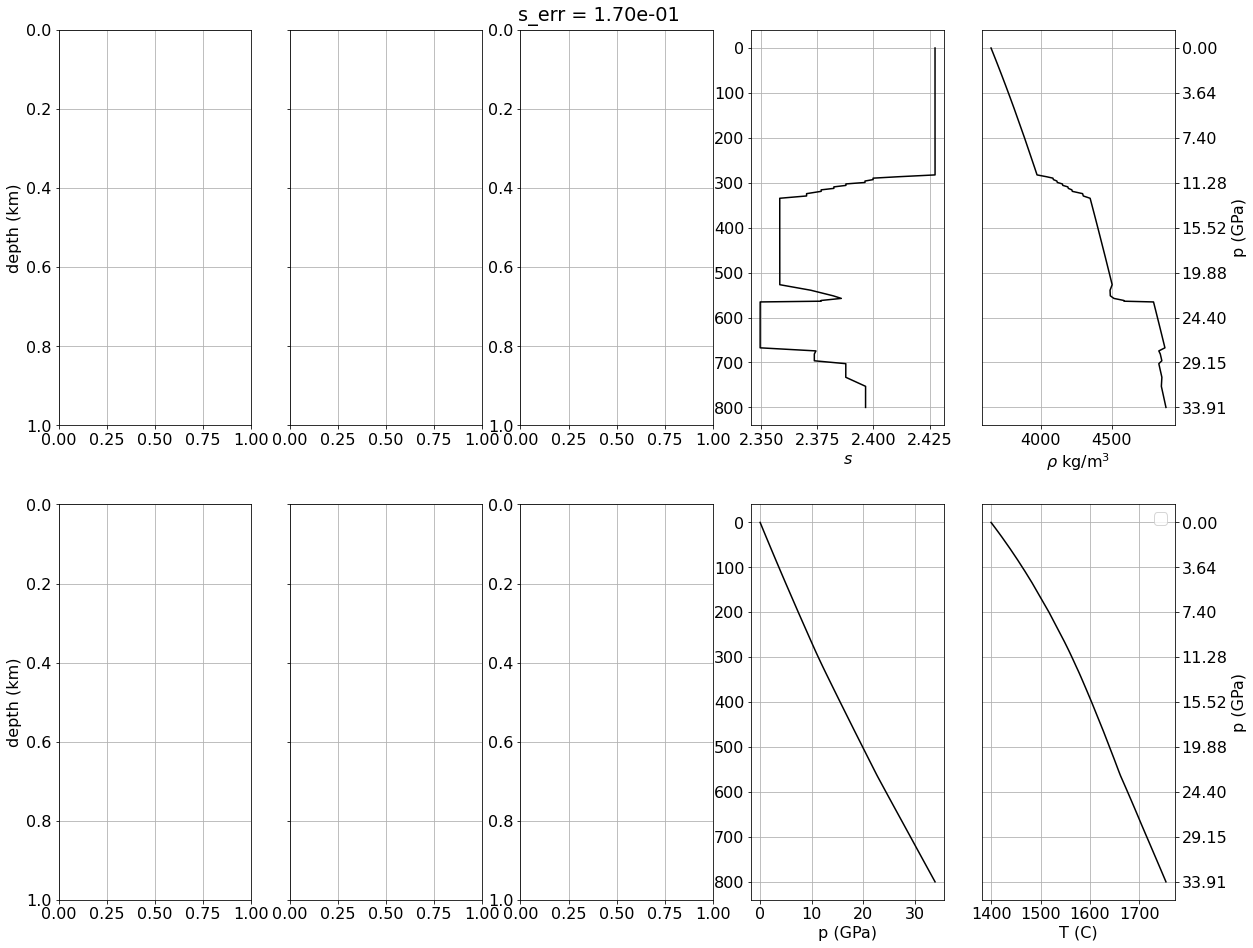

In [61]:
isen.plot()